In [72]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [75]:
pwd

'/content'

In [0]:
download = drive.CreateFile({'id':'1t19mxKOrFgePTGOvoCyaB-bj4EguQ4Cq'})

In [76]:
download.GetContentFile('train-scene-classification.zip')
!unzip train-scene-classification.zip

Archive:  train-scene-classification.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
mkdir data-test

In [0]:
cd data-test

/content/data-test


In [0]:
mkdir test_imgs

In [0]:
cd test_imgs

[Errno 2] No such file or directory: 'test_imgs'
/content/data-test/test_imgs


In [0]:
import os
import errno
import shutil
import pandas as pd

IMAGES ='/content/train'
DIR = '/content/data-test/test_imgs'


# Import training labels
data1 = pd.read_csv('test.csv')

# Moving files in respective directories
for images in data1['image_name']:
    shutil.move(IMAGES+'/'+images, DIR+'/'+images)

In [0]:
cd /..

/


In [0]:
cd content

/content


In [0]:
download = drive.CreateFile({'id':'1t19mxKOrFgePTGOvoCyaB-bj4EguQ4Cq'})
download.GetContentFile('train-scene-classification.zip')
!unzip train-scene-classification.zip

In [0]:
ls

adc.json    sample_data/  train/     train-scene-classification.zip
data-test/  test.csv      train.csv


In [0]:
mkdir models

In [0]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

In [2]:
train_path='/content/'
test_path='/content/'
df = pd.read_csv('train.csv')
df['label'].value_counts()
#Classes to be predicted
# buildings-0,forest-1,glacier-2,mountain-3,sea-4,street-5

3    3037
2    2957
5    2883
4    2784
1    2745
0    2628
Name: label, dtype: int64

In [3]:
df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [0]:

from fastai import *
from fastai.vision import *

In [0]:

path='/content/train/'

In [6]:
classes=['0','1','2','3','4','5']
p = Path('/content/data-train')
for c in classes:
  print(c)
  verify_images(p/c,delete=True,max_size=500)

0


1


2


3


4


5


In [0]:
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0.5)
data = (ImageList.from_folder(p) 
        .split_by_rand_pct()              
        .label_from_folder()            
        .add_test_folder(test_folder = '/content/data-test/test_imgs')              
        .transform(tfms, size=128)
        .databunch(num_workers=0))

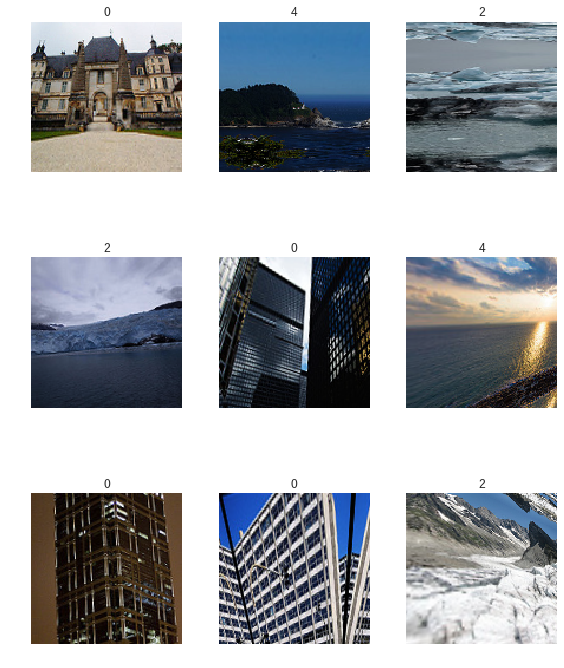

In [8]:
data.show_batch(rows=3, figsize=(8,10))

In [9]:
print(data.classes)

['0', '1', '2', '3', '4', '5']


In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], model_dir="/content/models/")


In [11]:
learn.fit_one_cycle(4)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.603848,0.336026,0.119495,0.880505,01:54
1,0.450844,0.281955,0.105696,0.894304,01:52
2,0.368380,0.243041,0.083382,0.916618,01:52
3,0.347653,0.234060,0.080740,0.919260,01:52


In [0]:
learn.save('/content/models/stage-1-34-128-v')

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

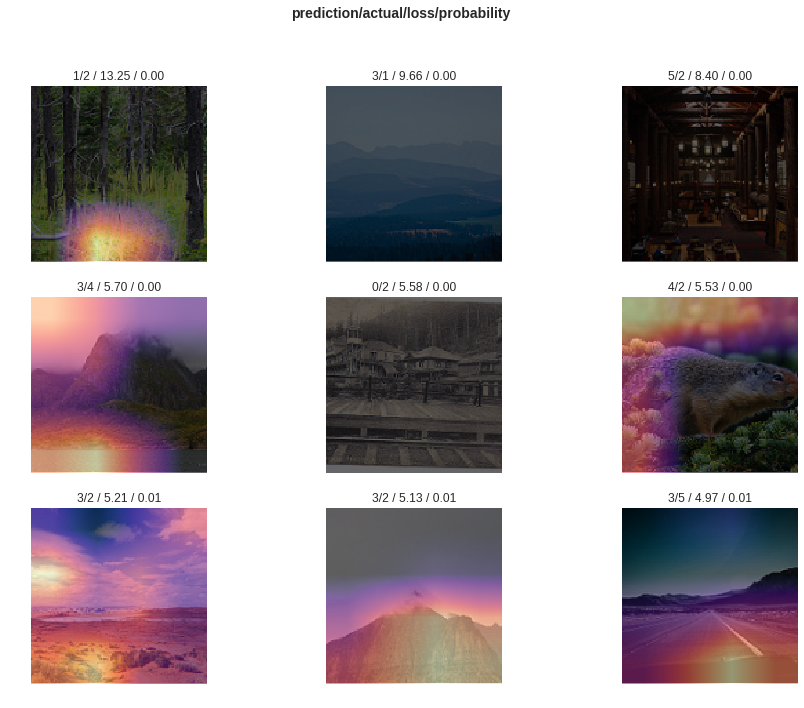

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

In [15]:
doc(interp.plot_top_losses)

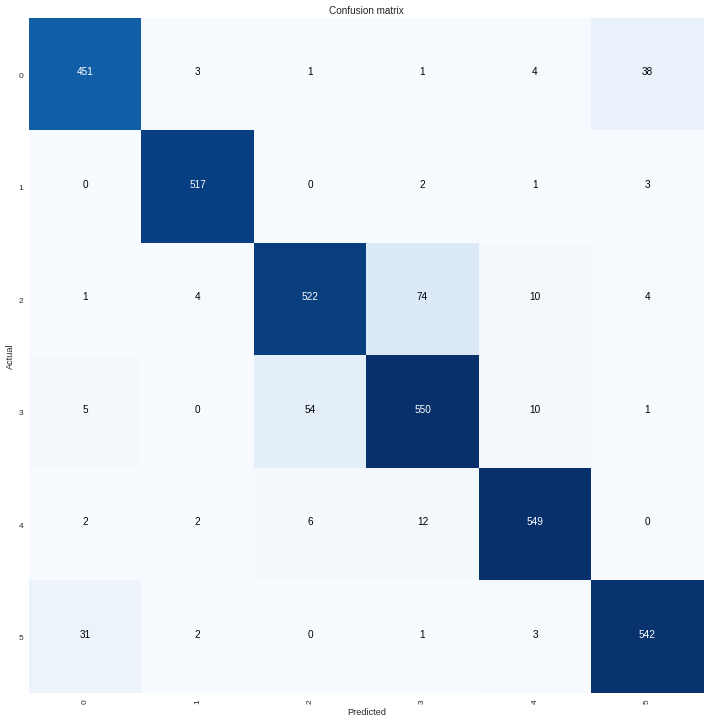

In [16]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [17]:
interp.most_confused(min_val=2)


[('2', '3', 74),
 ('3', '2', 54),
 ('0', '5', 38),
 ('5', '0', 31),
 ('4', '3', 12),
 ('2', '4', 10),
 ('3', '4', 10),
 ('4', '2', 6),
 ('3', '0', 5),
 ('0', '4', 4),
 ('2', '1', 4),
 ('2', '5', 4),
 ('0', '1', 3),
 ('1', '5', 3),
 ('5', '4', 3),
 ('1', '3', 2),
 ('4', '0', 2),
 ('4', '1', 2),
 ('5', '1', 2)]

In [0]:
learn.unfreeze()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


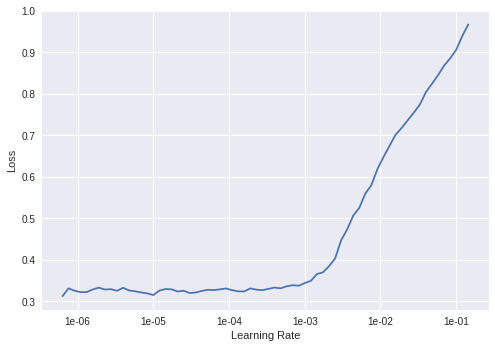

In [20]:
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.324165,0.220894,0.074868,0.925132,02:08
1,0.292136,0.207177,0.070757,0.929242,02:08
2,0.272108,0.199717,0.068996,0.931004,02:08
3,0.266645,0.200574,0.068996,0.931004,02:07


In [0]:
learn.save('/content/models/stage-2-34-128-v')

In [23]:
ls

adc.json    data-train/   submission.csv  train.csv
content/    models/       test.csv        train-scene-classification.zip
data-test/  sample_data/  train/


In [0]:
learn.export()

In [25]:
ls

adc.json    data-train/   submission.csv  train.csv
content/    models/       test.csv        train-scene-classification.zip
data-test/  sample_data/  train/


In [26]:
path = learn.path
print(path)

/content/data-train


In [0]:
learn = load_learner(path)

In [0]:
test = pd.read_csv('/content/test.csv')

In [0]:
images = []
prediction = []
probability = []
for i in test['image_name']:
  images.append(i)
  link = '/content/train'+'/'+i
  img = open_image(link)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()
answer.to_csv('/content/submission-v.csv')
  

In [0]:
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0.5)
data = (ImageList.from_csv(path, csv_name = '/content/train.csv') 
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '/content/data-test/test_imgs')              
        .transform(tfms, size=256)
        .databunch(num_workers=0)
        
       )  

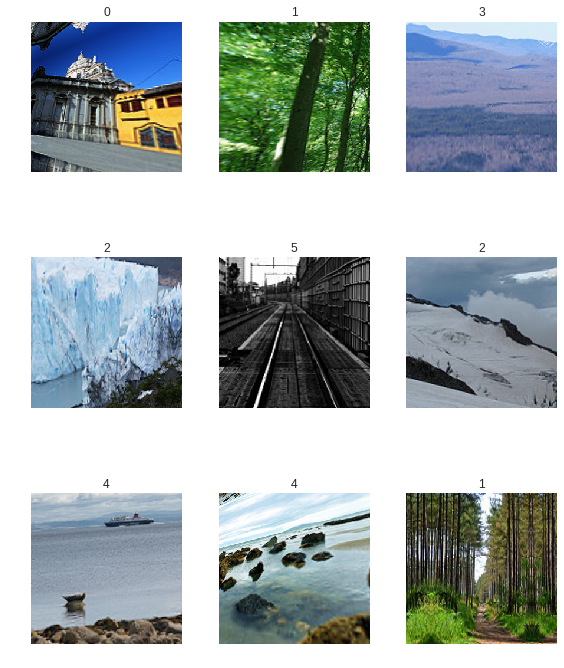

In [0]:
data.show_batch(rows=3, figsize=(8,10))

In [0]:
learn.load('/content/models/stage-2-34-128')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/train;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Basi

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

ZeroDivisionError: ignored

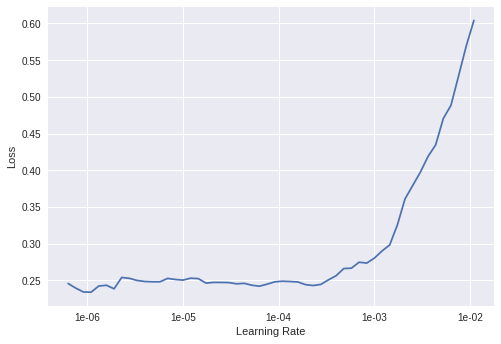

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.259126,0.209708,0.072519,0.927481,02:05
1,0.255745,0.204313,0.073693,0.926307,02:05
2,0.231671,0.201794,0.067528,0.932472,02:05
3,0.230863,0.200375,0.071638,0.928362,02:04


In [0]:
learn.export()

In [0]:
ls

In [0]:
learn = load_learner()